In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, classification_report

# Step 1: Data Loading and Preprocessing

In [2]:
def load_mri_data(data_dir):
    """Load MRI data from Nifti files."""
    images = []
    labels = []
    
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.nii') or file_name.endswith('.nii.gz'):
            file_path = os.path.join(data_dir, file_name)
            try:
                # Load MRI data
                mri_data = nib.load(file_path).get_fdata()
                images.append(mri_data)
                
                # Extract the subject number from the file name (e.g., "sub-101")
                if "sub-" in file_name:
                    subject_number = int(file_name.split('-')[1].split('_')[0])
                    # Assign label: sub-101 → 0, sub-102 → 1, ..., sub-115 → 14
                    labels.append(subject_number - 101)
                else:
                    print(f"Warning: Unable to extract label for file {file_name}")
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
    
    if not images:
        raise ValueError("No MRI data found in the specified directory.")
    
    return np.array(images), np.array(labels)


In [3]:
# Load Data
data_dir = '/kaggle/input/nonsmoking-schizo-from-1-to-25/sub1-25'
images, labels = load_mri_data(data_dir)

print(f"Loaded {len(images)} images and {len(labels)} labels.")
print(f"Labels: {labels}")


Loaded 25 images and 25 labels.
Labels: [10 16 12  1  3  0  7 18  2 14 13 19  9 24 22  4  5 15 21 20 11 17 23  8
  6]


# Normalize images to [0, 1]

In [4]:

images = (images - np.min(images)) / (np.max(images) - np.min(images))

# Ensure labels are sequentially remapped
unique_labels = np.unique(labels)
label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
labels = np.array([label_map[label] for label in labels])

# Convert labels to binary for binary classification
labels = (labels > 7).astype(int)

# Split data 
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)
# Reshape data
X_train = X_train.reshape(X_train.shape[0], 64, 64, 33, 240)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 33, 240)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (20, 64, 64, 33, 240)
Test data shape: (5, 64, 64, 33, 240)


In [5]:
print(f"Loaded {len(images)} images and {len(labels)} labels.")

# Check if images were loaded
if len(images) > 0:
    print(f"Image shape: {images[0].shape}")
else:
    print("No images loaded")

print(f"Labels: {labels}")


Loaded 25 images and 25 labels.
Image shape: (64, 64, 33, 240)
Labels: [1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0]


# Remap labels to be sequential

In [6]:

# Ensure labels are sequentially remapped
unique_labels = np.unique(labels)
label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
sequential_labels = np.array([label_map[label] for label in labels])

print(f"Original labels: {labels}")
print(f"Sequential labels: {sequential_labels}")
print(f"Label map: {label_map}")



Original labels: [1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0]
Sequential labels: [1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0]
Label map: {0: 0, 1: 1}


# Step 2: Model Definition

In [ ]:
''''def build_complex_3d_cnn(input_shape):
    """Builds a more complex 3D CNN model."""
    model = models.Sequential([
        layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(0.25),

        layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(0.25),

        layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu'),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(0.25),

        layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu'),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (64, 64, 33, 240)  # Depth, Height, Width, Channels
model = build_complex_3d_cnn(input_shape)

In [7]:
def build_3d_cnn(input_shape):
    """Builds the 3D CNN model."""
    model = models.Sequential([
        layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(0.25),

        layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(0.25),

        layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu'),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (64, 64, 33, 240)  # Depth, Height, Width, Channels
model = build_3d_cnn(input_shape)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Step 3: Training the Model

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


def custom_3d_data_generator(X, y, batch_size):
    """Custom data generator for 3D data."""
    while True:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            batch_indices = indices[start:end]
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]
            # Simplified data augmentation
            batch_X_aug = np.array([tf.image.random_flip_left_right(img) for img in batch_X])
            yield batch_X_aug, batch_y


from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Adjust learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Use the custom data generator with a smaller batch size
batch_size = 4
train_generator = custom_3d_data_generator(X_train, y_train, batch_size)

history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[reduce_lr, early_stopping],
                    verbose=1)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.6056 - loss: 1.1554 - val_accuracy: 0.6000 - val_loss: 0.6553 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.7229 - loss: 0.7981 - val_accuracy: 0.6000 - val_loss: 0.6808 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.7229 - loss: 0.6385 - val_accuracy: 0.6000 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.7785 - loss: 0.6208 - val_accuracy: 0.6000 - val_loss: 0.6665 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.7090 - loss: 0.4770 - val_accuracy: 0.6000 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.7229 - loss: 0.5679 - val_accuracy: 0.6000 - val_loss: 0.6794 - learning_rate: 0.0010
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.6812 - loss: 0.5455 - val_accuracy: 0.6000 - val_l

# Step 4: Evaluation

In [10]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Predict and calculate AUC
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {auc}")

# Classification report
y_pred_classes = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_classes))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step - accuracy: 0.6000 - loss: 0.6553
Test Loss: 0.6552659273147583, Test Accuracy: 0.6000000238418579
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
Test AUC: 1.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.60      1.00      0.75         3

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.37         5
weighted avg       0.36      0.60      0.45         5



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Step 5: Visualization

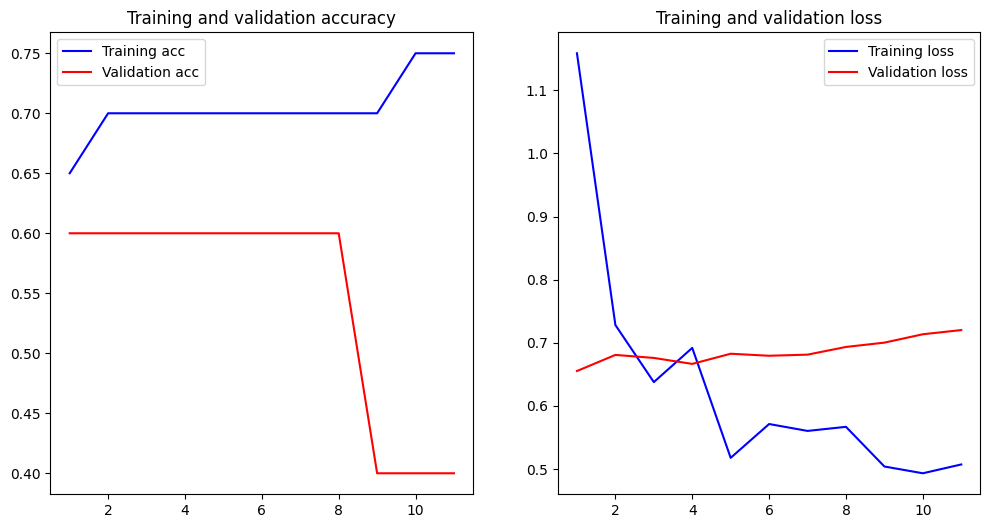

In [13]:
def plot_training_history(history):
    """Plots training and validation accuracy/loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)